In [1]:
# install necessary libraries and dependencies
!pip install sentence_transformers
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
from transformers import GPT2LMHeadModel, GPT2Tokenizer, AutoModelForCausalLM, AutoTokenizer
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scipy.stats as stats
from scipy.stats import anderson, levene, ttest_ind, ttest_ind_from_stats
from scipy.stats import shapiro
from scipy.stats import shapiro, ttest_rel, wilcoxon, chi2_contingency, fisher_exact, spearmanr
from statsmodels.stats.proportion import proportions_ztest

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 4.2 MB/s eta 0:00:00


In [ ]:
# load distilgpt model
distilgpt_model = AutoModelForCausalLM.from_pretrained("distilgpt2")
distilgpt_tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
distilgpt_tokenizer.pad_token = distilgpt_tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
# load gpt-2 model
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2")
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
# define the models and tokenizers dictionaries
models = {
    'DistilGPT': distilgpt_model,
    'GPT-2': gpt2_model
}

tokenizers = {
    'DistilGPT': distilgpt_tokenizer,
    'GPT-2': gpt2_tokenizer
}

In [ ]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
distilgpt_model.to(device)
gpt2_model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
# load the sampled data
sampled_df = pd.read_csv('/content/drive/My Drive/ITNPBD5 PROJECT/sampled_empathetic_dialogues.csv')

In [ ]:
# load sentence transformer for similarity calculation
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# perplexity calculation
def calculate_perplexity(model, tokenizer, text):
    try:
        encodings = tokenizer(text, return_tensors='pt').to(device)
        max_length = model.config.max_position_embeddings
        stride = 512
        seq_len = encodings.input_ids.size(1)

        nlls = []
        prev_end_loc = 0
        for begin_loc in range(0, seq_len, stride):
            end_loc = min(begin_loc + max_length, seq_len)
            trg_len = end_loc - prev_end_loc
            input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
            target_ids = input_ids.clone()
            target_ids[:, :-trg_len] = -100

            with torch.no_grad():
                outputs = model(input_ids, labels=target_ids)
                neg_log_likelihood = outputs.loss * trg_len

            nlls.append(neg_log_likelihood)
            prev_end_loc = end_loc
            if end_loc == seq_len:
                break

        if len(nlls) > 0:
            ppl = torch.exp(torch.stack(nlls).sum() / end_loc)
            return min(ppl.item(), 1e6)  # Cap at a large but finite value
        else:
            return 1e6  # A large but finite value for empty responses
    except Exception as e:
        print(f"Error calculating perplexity: {e}")
        return 1e6  # A large but finite value for errors

In [ ]:
# similarity score calculation
def calculate_lexical_similarity(text1, text2):
    try:
        embeddings = sentence_model.encode([text1, text2])
        similarity = cosine(embeddings[0], embeddings[1])
        return max(0, min(similarity, 1))  # Ensure it's between 0 and 1
    except Exception as e:
        print(f"Error calculating similarity: {e}")
        return 0  # Minimum similarity for errors

In [ ]:
# valid response
def is_valid_response(response, min_words=3, max_words=50):
    words = response.split()
    return min_words <= len(words) <= max_words and not any(char in response for char in "[](){}")

# set similarity threshold
SIMILARITY_THRESHOLD = 0.05

In [ ]:
# function for reponse generation
def generate_response(model, tokenizer, input_text, max_new_tokens=50):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)
    attention_mask = torch.ones(input_ids.shape, dtype=torch.long, device=device)
    output = model.generate(
        input_ids,
        attention_mask=attention_mask,
        max_new_tokens=max_new_tokens,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        do_sample=True,
        temperature=0.7,
        top_k=50,
        top_p=0.95,
        pad_token_id=tokenizer.eos_token_id
    )
    return tokenizer.decode(output[0], skip_special_tokens=True)

In [ ]:
# function for selecting demonstration example
def select_demonstration_examples(df, test_sample, n=5):
    return df[df['context'] != test_sample['context']].sample(n=n)

In [ ]:
# function for the five shot prompt
def construct_five_shot_prompt(demonstrations, test_sample):
    prompt = ""
    for i, demo in enumerate(demonstrations.itertuples(), 1):
        prompt += f"Example {i}:\n"
        prompt += f"Context: {demo.context}\n"
        prompt += f"Conversation: {demo.input}\n"
        prompt += f"Empathetic response: {demo.target}\n\n"

    prompt += "Now, respond to this:\n"
    prompt += f"Context: {test_sample['context']}\n"
    prompt += f"Conversation: {test_sample['input']}\n"
    prompt += "Empathetic response:"
    return prompt

In [ ]:
# function for running the experiment
def five_shot_experiment(model, tokenizer, df, num_generations=3):
    results = []
    empty_response_count = 0
    samples_with_valid_responses = 0

    for _, row in tqdm(df.iterrows(), total=len(df)):
        demonstration = select_demonstration_examples(df[df.index != row.name], row)
        one_shot_prompt = construct_five_shot_prompt(demonstration, row)

        valid_responses = []
        perplexities = []
        similarities = []

        for _ in range(num_generations):
            generated_response = generate_response(model, tokenizer, one_shot_prompt)
            clean_response = generated_response.split("Empathetic response:")[-1].strip()

            if clean_response and is_valid_response(clean_response):
                valid_responses.append(clean_response)
                perplexities.append(calculate_perplexity(model, tokenizer, clean_response))
                similarities.append(calculate_lexical_similarity(row['target'], clean_response))
            else:
                empty_response_count += 1

        if valid_responses:
            samples_with_valid_responses += 1
            avg_perplexity = np.mean(perplexities)
            avg_similarity = np.mean(similarities)
            best_response_idx = np.argmax(similarities)
            best_response = valid_responses[best_response_idx]
        else:
            avg_perplexity = 1e6
            avg_similarity = 0
            best_response = ""

        results.append({
            'context': row['context'],
            'prompt': row['prompt'],
            'input': row['input'],
            'target': row['target'],
            'generated_response': best_response,
            'avg_perplexity': avg_perplexity,
            'avg_lexical_similarity': avg_similarity,
            'num_valid_responses': len(valid_responses),
            'is_relevant': avg_similarity > SIMILARITY_THRESHOLD
        })

    print(f"Total empty responses: {empty_response_count}")
    print(f"Samples with at least one valid response: {samples_with_valid_responses}/{len(df)}")
    return pd.DataFrame(results)

In [ ]:
# run distilgpt experiment
print("Starting one-shot experiment with DistilGPT...")
distilgpt_results = five_shot_experiment(distilgpt_model, distilgpt_tokenizer, sampled_df)
distilgpt_results['model'] = 'DistilGPT'

Starting one-shot experiment with DistilGPT...


100%|██████████| 1000/1000 [17:29<00:00,  1.05s/it]

Total empty responses: 61
Samples with at least one valid response: 1000/1000


In [ ]:
# run gpt-2 small experiment
print("Starting one-shot experiment with GPT-2...")
gpt2_results = five_shot_experiment(gpt2_model, gpt2_tokenizer, sampled_df)
gpt2_results['model'] = 'GPT-2'

Starting one-shot experiment with GPT-2...


100%|██████████| 1000/1000 [28:49<00:00,  1.73s/it]

Total empty responses: 266
Samples with at least one valid response: 998/1000


In [ ]:
# save results
distilgpt_results.to_csv('/content/drive/My Drive/ITNPBD5 PROJECT/distilgpt_five_shot_results.csv', index=False)
gpt2_results.to_csv('/content/drive/My Drive/ITNPBD5 PROJECT/gpt2_five_shot_results.csv', index=False)

In [ ]:
# combine results
combined_results = pd.concat([distilgpt_results, gpt2_results], ignore_index=True)

In [ ]:
# save combined results
combined_results.to_csv('/content/drive/My Drive/ITNPBD5 PROJECT/five_shot_combined_results.csv', index=False)
print("Combined one-shot results saved.")

Combined one-shot results saved.


### Model Performnce and Descriptions

In [ ]:
# load the data
data = pd.read_csv('/content/drive/MyDrive/ITNPBD5 PROJECT/one_shot_combined_results.csv')
data['pair_id'] = data.groupby(['context', 'prompt', 'input', 'target']).ngroup()
valid_samples = data[data['num_valid_responses'] > 0].groupby('pair_id').filter(lambda x: len(x) == 2)
distilgpt_data = valid_samples[valid_samples['model'] == 'DistilGPT']
gpt2_data = valid_samples[valid_samples['model'] == 'GPT-2']

print("Total samples:", len(data) // 2)  # divide by 2 because each sample appears twice (once for each model)
print("Valid samples:", len(valid_samples) // 2)
print("DistilGPT samples:", len(distilgpt_data))
print("GPT-2 samples:", len(gpt2_data))

Total samples: 1000
Valid samples: 998
DistilGPT samples: 998
GPT-2 samples: 998


In [ ]:
# print model statistics
def print_model_statistics(df, model_name):
    print(f"\n--- {model_name} Statistics ---")
    print(f"Total samples: {len(df)}")
    print(f"Valid responses: {df['num_valid_responses'].sum()}")
    print(f"Samples with at least one valid response: {(df['num_valid_responses'] > 0).sum()}")

    print("\nPerplexity:")
    print(f" Mean: {df['avg_perplexity'].mean():.4f}")
    print(f" Median: {df['avg_perplexity'].median():.4f}")
    print(f" Std Dev: {df['avg_perplexity'].std():.4f}")
    print(f" Min: {df['avg_perplexity'].min():.4f}")
    print(f" Max: {df['avg_perplexity'].max():.4f}")

    print("\nLexical Similarity:")
    print(f" Mean: {df['avg_lexical_similarity'].mean():.4f}")
    print(f" Median: {df['avg_lexical_similarity'].median():.4f}")
    print(f" Std Dev: {df['avg_lexical_similarity'].std():.4f}")
    print(f" Min: {df['avg_lexical_similarity'].min():.4f}")
    print(f" Max: {df['avg_lexical_similarity'].max():.4f}")

    print("\nZero Similarity Scores:")
    zero_sim = (df['avg_lexical_similarity'] == 0).sum()
    print(f" Count: {zero_sim}")
    print(f" Percentage: {zero_sim / len(df) * 100:.2f}%")

print_model_statistics(distilgpt_results, "DistilGPT")
print_model_statistics(gpt2_results, "GPT-2")


--- DistilGPT Statistics ---
Total samples: 1000
Valid responses: 2939
Samples with at least one valid response: 1000

Perplexity:
 Mean: 23.1371
 Median: 21.3507
 Std Dev: 10.2008
 Min: 10.7982
 Max: 214.7044

Lexical Similarity:
 Mean: 0.8280
 Median: 0.8366
 Std Dev: 0.0885
 Min: 0.5116
 Max: 1.0000

Zero Similarity Scores:
 Count: 0
 Percentage: 0.00%

--- GPT-2 Statistics ---
Total samples: 1000
Valid responses: 2734
Samples with at least one valid response: 998

Perplexity:
 Mean: 2027.1756
 Median: 21.2408
 Std Dev: 44697.7883
 Min: 12.1539
 Max: 1000000.0000

Lexical Similarity:
 Mean: 0.7998
 Median: 0.8144
 Std Dev: 0.1136
 Min: 0.0000
 Max: 1.0000

Zero Similarity Scores:
 Count: 2
 Percentage: 0.20%


In [ ]:
# print more info from both experiments
def calculate_metrics(df):
    total_samples = len(df)
    relevant_responses = (df['avg_lexical_similarity'] > SIMILARITY_THRESHOLD).sum()
    avg_perplexity = df[df['avg_perplexity'] != float('inf')]['avg_perplexity'].mean()

    print(f"Total samples: {total_samples}")
    print(f"Relevant responses: {relevant_responses} ({relevant_responses/total_samples*100:.2f}%)")
    print(f"Average perplexity : {avg_perplexity:.4f}")
    print(f"Responses with perplexity < 20: {(df['avg_perplexity'] < 20).sum()/total_samples*100:.2f}%")

print("DistilGPT Metrics:")
calculate_metrics(distilgpt_results)

print("\nGPT-2 Metrics:")
calculate_metrics(gpt2_results)

DistilGPT Metrics:
Total samples: 1000
Relevant responses: 1000 (100.00%)
Average perplexity : 23.1371
Responses with perplexity < 20: 34.40%

GPT-2 Metrics:
Total samples: 1000
Relevant responses: 998 (99.80%)
Average perplexity : 2027.1756
Responses with perplexity < 20: 39.10%


In [ ]:
# print additional info on model performance
def report_model_performance(df, model_name):
    total_samples = len(df)
    relevant_responses = df['is_relevant'].sum()
    relevant_df = df[df['is_relevant']]

    print(f"{model_name} Performance:")
    print(f"Total samples: {total_samples}")
    print(f"Relevant responses: {relevant_responses} ({relevant_responses/total_samples*100:.2f}%)")
    print(f"Average similarity (relevant only): {relevant_df['avg_lexical_similarity'].mean():.4f}")
    print(f"Average perplexity (relevant only): {relevant_df['avg_perplexity'].mean():.4f}")

    similarity_bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1]
    similarity_distribution = pd.cut(df['avg_lexical_similarity'], bins=similarity_bins).value_counts().sort_index()
    print("\nSimilarity Distribution:")
    print(similarity_distribution)
    print("---")

report_model_performance(distilgpt_results, "DistilGPT")
report_model_performance(gpt2_results, "GPT-2")

DistilGPT Performance:
Total samples: 1000
Relevant responses: 1000 (100.00%)
Average similarity (relevant only): 0.8280
Average perplexity (relevant only): 23.1371

Similarity Distribution:
avg_lexical_similarity
(0.0, 0.1]       0
(0.1, 0.2]       0
(0.2, 0.3]       0
(0.3, 0.4]       0
(0.4, 0.5]       0
(0.5, 1.0]    1000
Name: count, dtype: int64
---
GPT-2 Performance:
Total samples: 1000
Relevant responses: 998 (99.80%)
Average similarity (relevant only): 0.8014
Average perplexity (relevant only): 27.2301

Similarity Distribution:
avg_lexical_similarity
(0.0, 0.1]      0
(0.1, 0.2]      0
(0.2, 0.3]      0
(0.3, 0.4]      0
(0.4, 0.5]      8
(0.5, 1.0]    990
Name: count, dtype: int64
---


In [ ]:
# check the count of valid and distributions of responses
for model_name in ['DistilGPT', 'GPT-2']:
    model_results = data[data['model'] == model_name]
    response_distribution = model_results['num_valid_responses'].value_counts().sort_index()
    print(f"\n{model_name} valid response distribution:")
    print(response_distribution)
    print(f"Samples with at least one valid response: {(model_results['num_valid_responses'] > 0).sum()}/{len(model_results)}")


DistilGPT valid response distribution:
num_valid_responses
1      4
2     95
3    901
Name: count, dtype: int64
Samples with at least one valid response: 1000/1000

GPT-2 valid response distribution:
num_valid_responses
0      2
1     26
2    207
3    765
Name: count, dtype: int64
Samples with at least one valid response: 998/1000


### Statistical tests for lexical similarity and perplexity:

In [ ]:
# load the results
distilgpt_results = pd.read_csv('/content/drive/My Drive/ITNPBD5 PROJECT/distilgpt_five_shot_results.csv')
gpt2_results = pd.read_csv('/content/drive/My Drive/ITNPBD5 PROJECT/gpt2_five_shot_results.csv')

In [ ]:
# load the data
data = pd.read_csv('/content/drive/MyDrive/ITNPBD5 PROJECT/five_shot_combined_results.csv')
data['pair_id'] = data.groupby(['context', 'prompt', 'input', 'target']).ngroup()
valid_samples = data[data['num_valid_responses'] > 0].groupby('pair_id').filter(lambda x: len(x) == 2)
distilgpt_data = valid_samples[valid_samples['model'] == 'DistilGPT']
gpt2_data = valid_samples[valid_samples['model'] == 'GPT-2']

In [ ]:
gpt2_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 998 entries, 1000 to 1999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   context                 998 non-null    object 
 1   prompt                  998 non-null    object 
 2   input                   998 non-null    object 
 3   target                  998 non-null    object 
 4   generated_response      998 non-null    object 
 5   avg_perplexity          998 non-null    float64
 6   avg_lexical_similarity  998 non-null    float64
 7   num_valid_responses     998 non-null    int64  
 8   is_relevant             998 non-null    bool   
 9   model                   998 non-null    object 
 10  pair_id                 998 non-null    int64  
dtypes: bool(1), float64(2), int64(2), object(6)
memory usage: 86.7+ KB


In [ ]:
# ensure data is aligned
distilgpt_data = distilgpt_data.reset_index(drop=True)
gpt2_data = gpt2_data.reset_index(drop=True)

In [ ]:
distilgpt_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   context                 998 non-null    object 
 1   prompt                  998 non-null    object 
 2   input                   998 non-null    object 
 3   target                  998 non-null    object 
 4   generated_response      998 non-null    object 
 5   avg_perplexity          998 non-null    float64
 6   avg_lexical_similarity  998 non-null    float64
 7   num_valid_responses     998 non-null    int64  
 8   is_relevant             998 non-null    bool   
 9   model                   998 non-null    object 
 10  pair_id                 998 non-null    int64  
dtypes: bool(1), float64(2), int64(2), object(6)
memory usage: 79.1+ KB


In [ ]:
# hypothesis tests experiment
def paired_hypothesis_test(distilgpt_data, gpt2_data, metric):
    print(f"\nHypothesis Test for {metric.capitalize()}:")
    print(f"Null Hypothesis (H0): There is no difference in mean {metric} between DistilGPT and GPT-2 small.")
    print(f"Alternative Hypothesis (H1): There is a difference in mean {metric} between DistilGPT and GPT-2 small.")

    alpha = 0.05
    print(f"Significance level: {alpha}")

    differences = distilgpt_data[metric] - gpt2_data[metric]

    # Normality test
    _, p_value_normal = stats.normaltest(differences)
    print(f"Normality test p-value: {p_value_normal:.4f}")

    if p_value_normal > 0.05:  # Normal distribution
        statistic, p_value = stats.ttest_rel(distilgpt_data[metric], gpt2_data[metric])
        test_name = "Paired t-test"
    else:  # Non-normal distribution
        statistic, p_value = stats.wilcoxon(differences)
        test_name = "Wilcoxon signed-rank test"

    # Effect size calculation
    effect_size = (np.mean(differences) / np.std(differences, ddof=1))

    # Confidence interval
    ci = stats.t.interval(confidence=0.95, df=len(differences)-1,
                          loc=np.mean(differences),
                          scale=stats.sem(differences))

    print(f"\nTest Results:")
    print(f"Test conducted: {test_name}")
    print(f"Test statistic: {statistic:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Effect size (Cohen's d): {effect_size:.4f}")
    print(f"95% Confidence Interval: ({ci[0]:.4f}, {ci[1]:.4f})")

    if p_value < alpha:
        decision = "Reject the null hypothesis"
        conclusion = f"There is a statistically significant difference in {metric} between DistilGPT and GPT-2 small."
    else:
        decision = "Fail to reject the null hypothesis"
        conclusion = f"There is not enough evidence to conclude a significant difference in {metric} between DistilGPT and GPT-2 small."

    print(f"\nDecision: {decision}")
    print(f"Conclusion: {conclusion}")

    if effect_size < 0.2:
        effect_size_interpretation = "small"
    elif effect_size < 0.5:
        effect_size_interpretation = "medium"
    else:
        effect_size_interpretation = "large"

    print(f"\nThe effect size is {effect_size_interpretation} (Cohen's d = {effect_size:.4f}).")

    if ci[0] * ci[1] > 0:
        ci_interpretation = f"favors {'DistilGPT' if ci[0] > 0 else 'GPT-2'}"
    else:
        ci_interpretation = "includes zero, indicating uncertainty in the direction of the effect"

    print(f"The 95% confidence interval {ci_interpretation}.")

# run the tests
paired_hypothesis_test(distilgpt_data, gpt2_data, 'avg_perplexity')
paired_hypothesis_test(distilgpt_data, gpt2_data, 'avg_lexical_similarity')


Hypothesis Test for Avg_perplexity:
Null Hypothesis (H0): There is no difference in mean avg_perplexity between DistilGPT and GPT-2 small.
Alternative Hypothesis (H1): There is a difference in mean avg_perplexity between DistilGPT and GPT-2 small.
Significance level: 0.05
Normality test p-value: 0.0000

Test Results:
Test conducted: Wilcoxon signed-rank test
Test statistic: 239140.0000
p-value: 0.2670
Effect size (Cohen's d): -0.0723
95% Confidence Interval: (-7.5973, -0.5775)

Decision: Fail to reject the null hypothesis
Conclusion: There is not enough evidence to conclude a significant difference in avg_perplexity between DistilGPT and GPT-2 small.

The effect size is small (Cohen's d = -0.0723).
The 95% confidence interval favors GPT-2.

Hypothesis Test for Avg_lexical_similarity:
Null Hypothesis (H0): There is no difference in mean avg_lexical_similarity between DistilGPT and GPT-2 small.
Alternative Hypothesis (H1): There is a difference in mean avg_lexical_similarity between Dis

### Sample Generation

In [ ]:
# load the data
data = pd.read_csv('/content/drive/MyDrive/ITNPBD5 PROJECT/five_shot_combined_results.csv')

In [ ]:
# load the results
distilgpt_results = pd.read_csv('/content/drive/My Drive/ITNPBD5 PROJECT/distilgpt_five_shot_results.csv')
gpt2_results = pd.read_csv('/content/drive/My Drive/ITNPBD5 PROJECT/gpt2_five_shot_results.csv')

In [ ]:
# load the sample index from the file in on the drive
sample_index_file = '/content/drive/My Drive/sample_index.json'
with open(sample_index_file, 'r') as f:
    sample_index = json.load(f)

specific_sample = sampled_df.iloc[sample_index]

In [ ]:
def select_demonstrations(df, test_sample, n=5):
    return df[df.index != test_sample.name].sample(n=n)

In [ ]:
# function for the one shot prompt
def construct_five_shot_prompt(demonstrations, test_sample):
    prompt = ""
    for i, demo in enumerate(demonstrations.itertuples(), 1):
        prompt += f"Example {i}:\n"
        prompt += f"Context: {demo.context}\n"
        prompt += f"Conversation: {demo.input}\n"
        prompt += f"Empathetic response: {demo.target}\n\n"
    prompt += "Now, respond to this:\n"
    prompt += f"Context: {test_sample['context']}\n"
    prompt += f"Conversation: {test_sample['input']}\n"
    prompt += "Empathetic response:"
    return prompt

In [ ]:
# function for running the experiment
def five_shot_generation(df, models, tokenizers, specific_sample):
    demonstrations = select_demonstrations(df, specific_sample)
    prompt = construct_five_shot_prompt(demonstrations, specific_sample)

    responses = {}
    metrics = {}

    for model_name, model in models.items():
        tokenizer = tokenizers[model_name]
        best_response = None
        best_perplexity = float('inf')
        best_similarity = 0  # Initialize to worst case for cosine similarity (0 to 1 range)

        for _ in range(3):  # 3 attempts
            response = generate_response(model, tokenizer, prompt)
            clean_response = response.split("Empathetic response:")[-1].strip()
            perplexity = min(calculate_perplexity(model, tokenizer, clean_response), 1e6)  # Cap perplexity at 1e6
            similarity = calculate_lexical_similarity(specific_sample['target'], clean_response)

            if similarity > best_similarity or (similarity == best_similarity and perplexity < best_perplexity):
                best_response = clean_response
                best_perplexity = perplexity
                best_similarity = similarity

        responses[model_name] = best_response
        metrics[model_name] = {'perplexity': best_perplexity, 'similarity': best_similarity}

    return {
        'demonstrations': demonstrations,
        'sample': specific_sample,
        'responses': responses,
        'metrics': metrics
    }

In [ ]:
# function for ten runs
def run_multiple_experiments(df, models, tokenizers, specific_sample, num_runs=10):
    all_results = []

    for _ in range(num_runs):
        result = five_shot_generation(df, models, tokenizers, specific_sample)
        all_results.append(result)

    return all_results

In [ ]:
# aggregate results from the runs and print best performance metrics
def aggregate_results(all_results):
    aggregated = {model: {'perplexity': [], 'similarity': []} for model in models}
    best_responses = {model: {'response': '', 'perplexity': float('inf'), 'similarity': 0} for model in models}

    for result in all_results:
        for model in models:
            perplexity = result['metrics'][model]['perplexity']
            similarity = result['metrics'][model]['similarity']

            aggregated[model]['perplexity'].append(perplexity)
            aggregated[model]['similarity'].append(similarity)

            # update best response if current one is better (higher similarity for cosine similarity)
            if similarity > best_responses[model]['similarity'] or \
               (similarity == best_responses[model]['similarity'] and perplexity < best_responses[model]['perplexity']):
                best_responses[model] = {
                    'response': result['responses'][model],
                    'perplexity': perplexity,
                    'similarity': similarity
                }

    for model in models:
        print(f"\n{model} Statistics (over {len(all_results)} runs):")
        print(f"Perplexity - Mean: {np.mean(aggregated[model]['perplexity']):.4f}")
        print(f"Similarity - Mean: {np.mean(aggregated[model]['similarity']):.4f}")
        print("\nBest Generated Response:")
        print(best_responses[model]['response'])
        print(f"Best Response Metrics - Perplexity: {best_responses[model]['perplexity']:.4f}, "
              f"Similarity: {best_responses[model]['similarity']:.4f}")
        print()

all_results = run_multiple_experiments(sampled_df, models, tokenizers, specific_sample, num_runs=10)

print("Demonstration examples (from first run):")
for i, demo in enumerate(all_results[0]['demonstrations'].itertuples(), 1):
    print(f"Example {i}:")
    print(f"Context: {demo.context}")
    print(f"Conversation: {demo.input}")
    print(f"Actual response: {demo.target}")
    print()

print("Sample for generation:")
print(f"Context: {specific_sample['context']}")
print(f"Conversation: {specific_sample['input']}")
print(f"Actual response: {specific_sample['target']}")

# Print aggregated results and best responses
aggregate_results(all_results)

Demonstration examples (from first run):
Example 1:
Context: guilty
Conversation: i felt bad after my partner discovered that i was cheating him
Actual response: well, you should.you did a nasty thing.

Example 2:
Context: confident
Conversation: i was nervous about an upcoming job interview recently, i bought a new outfit and got a haircut to make myself feel better. do you feel any less nervous? job interviews are always nerve-wracking yea, it made me feel better about myself and my chances, or maybe i just like spending money
Actual response: either way, as long as you feel a little bit better it was worth it. i'm sure you'll do great!

Example 3:
Context: sad
Conversation: my grandmother passed away about 10 years ago. i really miss her, she pretty much was the only female influence i had growing up.
Actual response: sorry to hear that. my grandmother is all i have left. grandpa passed 1 month ago

Example 4:
Context: disgusted
Conversation: i can't believe the state of our politic

## Similarity Graph

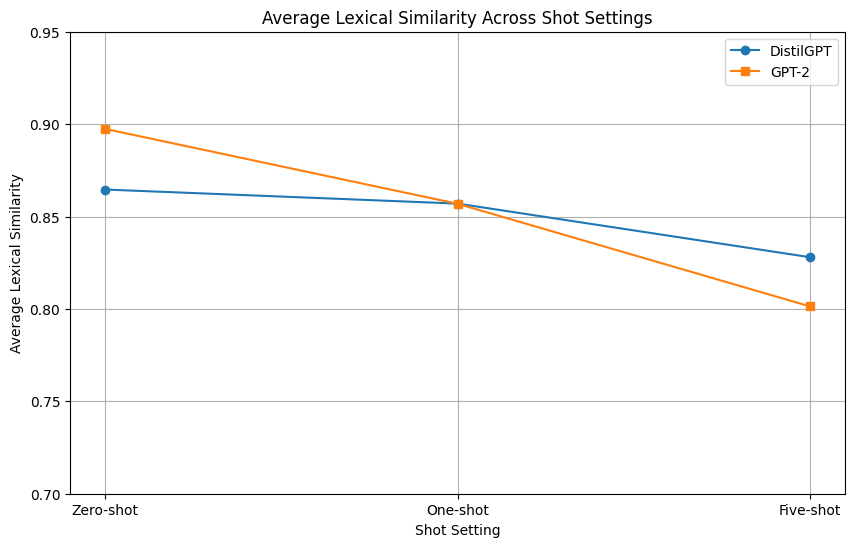

In [ ]:
distilgpt_similarity = [0.8646, 0.8570, 0.8280]
gpt2_similarity = [0.8974, 0.8569, 0.8014]

plt.figure(figsize=(10, 6))
plt.plot(shot_settings, distilgpt_similarity, marker='o', label='DistilGPT')
plt.plot(shot_settings, gpt2_similarity, marker='s', label='GPT-2')
plt.xlabel('Shot Setting')
plt.ylabel('Average Lexical Similarity')
plt.title('Average Lexical Similarity Across Shot Settings')
plt.legend()
plt.grid(True)
plt.ylim(0.7, 0.95)  # Adjust y-axis for better visualization
plt.show()